In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def extractAndResizeVideoFrames(cap):
  framesCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  frames = np.empty((frameHeight//2, frameWidth//2, framesCount))

  for cnt in range(framesCount):
    _, frame = cap.read()

    grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    frames[:,:,cnt] = cv2.resize(grayFrame, None, fx=0.5, fy=0.5)

  return frames.astype(np.uint8)



def trackFeatures(I, detector, maxCorners, qualityLevel, minDistance):
  if detector=="harris":
    useHarrisDetector = True
  else: 
    useHarrisDetector=False

  features = cv2.goodFeaturesToTrack(I, maxCorners, qualityLevel, minDistance, blockSize=7, useHarrisDetector=useHarrisDetector)

  return features


def showInterestPoints(image, corners):
  img = image.copy()

  plt.imshow(img, cmap='gray')
  for i in corners:
      x,y = i.ravel()
      circle = plt.Circle((x,y), color='r')
      plt.gcf().gca().add_artist(circle)
  plt.show()

In [3]:
cap = cv2.VideoCapture("Team30.mp4")
frames = extractAndResizeVideoFrames(cap)
cap.release()
print(frames.shape)

(360, 640, 2809)


In [4]:
firstFrame = frames[:,:,0]

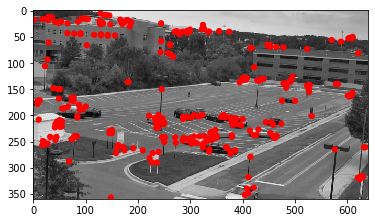

In [5]:
corners = trackFeatures(firstFrame, 'shi-tomasi',maxCorners = 300, qualityLevel = 0.1, minDistance = 2)
showInterestPoints(firstFrame, corners)

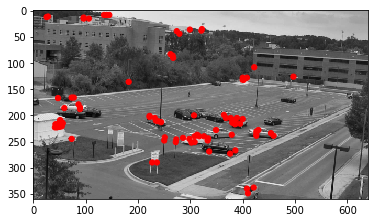

In [8]:
corners_h = trackFeatures(firstFrame,'harris',maxCorners = 300, qualityLevel = 0.1, minDistance = 1)
showInterestPoints(firstFrame, corners_h)